This notebook is for comparing the gap filling techniques visually

In [276]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch

In [277]:
# First import the model
from modules.MLPstuff import MLP
from modules.util import grab_data

In [288]:
# Load the data on which predictions and or gap filling are to be done
from columns import COLS_FEATURES, COLS_LABELS, COLS_TIME
input, target, dim_in, dim_out = grab_data('data/training_data_merged.csv', columns_data=COLS_FEATURES, columns_labels=COLS_LABELS, return_dataset = False )
data = pd.concat([input, target], axis=1)
print(input.shape)
print(target.shape)
print(data.shape)

ValueError: not enough values to unpack (expected 4, got 3)

In [279]:
# Load the model
model = MLP(dim_in, dim_out, num_hidden_units=30, num_hidden_layers=4)
model.load_state_dict(torch.load('model_saves/mlp_1.pth'))
model.eval()

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=12, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): ReLU()
    (4): Linear(in_features=30, out_features=30, bias=True)
    (5): ReLU()
    (6): Linear(in_features=30, out_features=30, bias=True)
    (7): ReLU()
    (8): Linear(in_features=30, out_features=30, bias=True)
    (9): ReLU()
    (10): Linear(in_features=30, out_features=2, bias=True)
  )
)

In [280]:
# Get an overview about NaNs per Row to remove input data nans
nan_counts = input.isnull().sum()
print("NaNs per column:")
print(nan_counts)

NaNs per column:
day                           0
waterPressureDeficit          0
month                         0
outgoingShortwaveRadiation    0
waterVaporPressure            0
soilHeatflux                  0
location                      0
airPressure                   0
year                          0
windSpeed                     0
30min                         0
incomingShortwaveRadiation    0
dtype: int64


In [234]:
# identify rows where labels are NaN, but features aren't
mask_nan = data[COLS_LABELS].isna().any(axis=1)
mask_not_nan = data[COLS_FEATURES].notna().all(axis=1)

# Combine the masks
combined_mask = mask_nan & mask_not_nan

# data used for prediction
input = data[combined_mask][COLS_FEATURES].reset_index(drop=True)

In [235]:
print(data[data[COLS_LABELS].isna().any(axis=1)].shape)
print(input.shape)

(0, 14)
(0, 12)


In [257]:
input.head()

,day,waterPressureDeficit,month,outgoingShortwaveRadiation,waterVaporPressure,soilHeatflux,location,airPressure,year,windSpeed,30min,incomingShortwaveRadiation
0,16,2.131392,2,87.725333,6.857902,6.283667,0,996.140667,2023,1.988667,23,408.582000
1,16,2.456927,2,53.086667,6.827809,11.058000,0,995.548000,2023,1.910667,25,256.372000
2,16,2.997957,2,82.873667,7.012585,10.838333,0,995.325667,2023,1.548333,26,371.893667
3,16,3.479701,2,78.387333,6.975607,13.126333,0,994.989667,2023,2.116000,27,342.721000
4,16,3.488345,2,62.984667,7.070665,14.722000,0,994.960000,2023,1.428333,28,279.880333


In [281]:
# transform input into torch.tensor and make predictions
input_tensor = torch.tensor(input.values, dtype=torch.float32)

with torch.no_grad():
    pred = model(input_tensor).numpy() #  Transform back to numpy 
# create dataframe of predictions with target rows and the indices of the missing values
pred = pd.DataFrame(pred, columns=target.columns)

# merge predictions onto features
data_pred = pd.concat([input, pred], axis=1)


In [287]:
input_tensor.data

tensor([[ 16.0000,   2.1314,   2.0000,  ...,   1.9887,  23.0000, 408.5820],
        [ 16.0000,   2.4569,   2.0000,  ...,   1.9107,  25.0000, 256.3720],
        [ 16.0000,   2.9980,   2.0000,  ...,   1.5483,  26.0000, 371.8937],
        ...,
        [ 30.0000,   1.6388,   6.0000,  ...,   2.9223,  45.0000,  -1.4760],
        [ 30.0000,   1.8795,   6.0000,  ...,   0.5137,  46.0000,  -2.0417],
        [ 30.0000,   1.5369,   6.0000,  ...,   2.8293,  46.0000,  -1.0850]])

In [282]:
input_tensor.shape

torch.Size([11655, 12])

In [283]:
pred.head()

,H_orig,LE_orig
0,-402.012909,1124.145752
1,-405.997070,1138.849487
2,-404.942291,1130.253540
3,-406.366852,1134.293579
4,-407.984894,1140.052002


In [284]:
target.head()

,H_orig,LE_orig
0,93.76650,112.710
1,51.96510,30.423
2,69.53238,39.713
3,71.31974,39.382
4,48.84439,32.021


In [285]:
df_test = (pred - target) ** 2
df_test.mean()

H_orig     1.884849e+05
LE_orig    1.069379e+06
dtype: float64

In [222]:
print(data_pred.shape)
print(input.shape)
print(pred.shape)

(15378, 14)
(15378, 12)
(15378, 2)


In [223]:
# create new column indicating that it is a prediction
data_pred["pred"] = 'red'

# create original dataframe
data_orig = data[~mask_nan].reset_index(drop=True)
data_orig["pred"] = 'blue'
data_plot = pd.concat([data_orig, data_pred])

In [224]:
print(data_pred.shape)
print(data_orig.shape)
print(data_plot.shape)

(15378, 15)
(12040, 15)
(27418, 15)


In [225]:
# filter by location and sort by date
data_plot_bg = data_plot[data_plot["location"] == 0].sort_values(by=['year', 'month', 'day', '30min'])
data_plot_gw = data_plot[data_plot["location"] == 1].sort_values(by=['year', 'month', 'day', '30min'])

In [226]:
print(data_plot_bg[data_plot_bg["pred"] == 'red'].shape)
print(data_plot_bg[data_plot_bg["pred"] == 'blue'].shape)

(9249, 15)
(5285, 15)


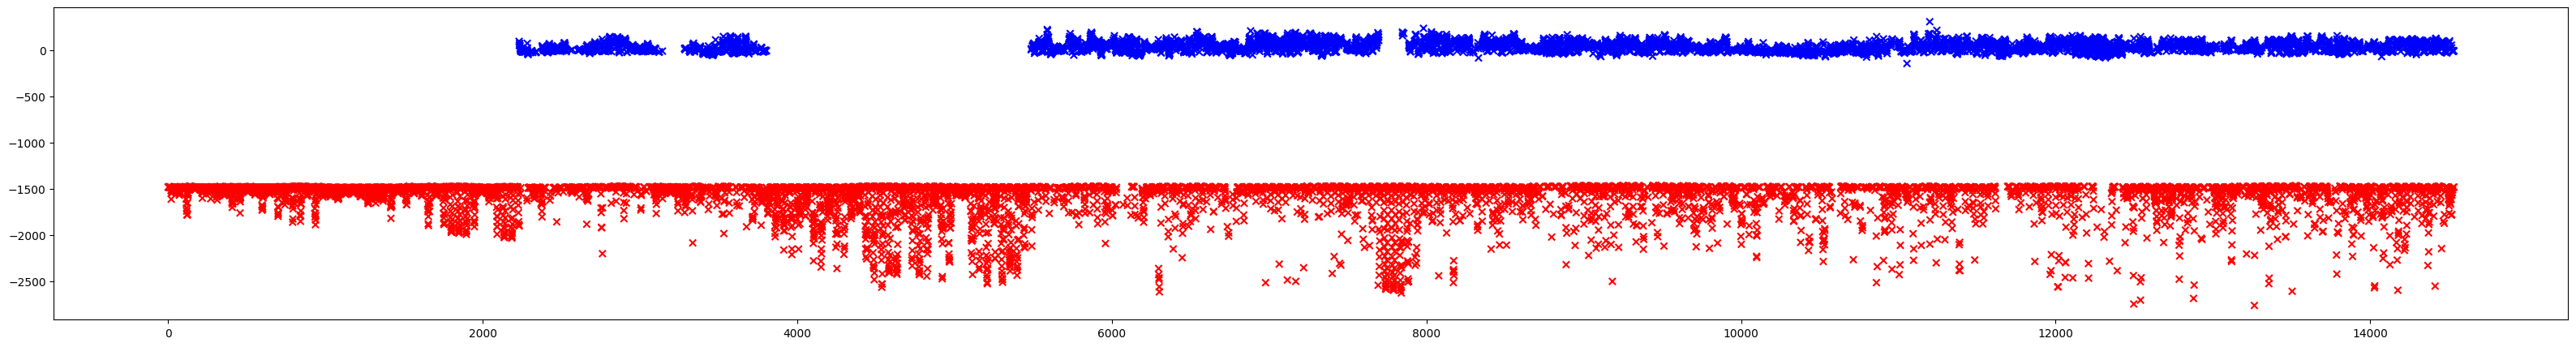

In [227]:
# Create plots of the filled frame

time = np.arange(data_plot_bg.shape[0])

plt.figure(figsize=(40,5))
plt.scatter(time, data_plot_bg['H_orig'].to_numpy(), marker='x', c=data_plot_bg['pred'])
# plt.plot(time, target['H_orig'].to_numpy(), linestyle='dotted' )